# Question Answering with a Fine-Tuned **Electra**


## 1. Install transformers library

In [1]:
!git clone https://github.com/aub-mind/arabert.git
!pip install transformers
!pip install pyarabic

fatal: destination path 'arabert' already exists and is not an empty directory.



[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from transformers import ElectraForQuestionAnswering
from transformers import AutoTokenizer
from arabert.preprocess import ArabertPreprocessor

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load AraElectra-Arabic-SQuADv2-QA

In [3]:
model = ElectraForQuestionAnswering.from_pretrained("ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA")
tokenizer = AutoTokenizer.from_pretrained("ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA")
prep_object = ArabertPreprocessor("araelectra-base-discriminator")

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DELL\.cache\huggingface\hub\models--ZeyadAhmed--AraElectra-Arabic-SQuADv2-QA. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


## **3**. Ask a Question

Feed a preprocessed example
Arbelectra preprocessor used for preprocessing the dataset in creation and training/testing.
It is recommended to apply the Arabert preprocessing function before training/testing on any dataset.

In [4]:

question = prep_object.preprocess("ما هي عاصمة فلسطين؟")
answer_text = prep_object.preprocess(" عاصمة فلسطين هي مدينة القدس ، كانت تسمى قديماً يبوس. تقع مدينة القدس في وسط فلسطين. فتحها الخليفة عمر بن الخطاب، الذي بنى المسجد الاقصى في القدس هو الخليفة الاموي عبد الملك بن مروان، والذي بنى قبة الصخرة هو ابنه الوليد بن عبد الملك ")

We'll need to run the Electra tokenizer against both the `question` and the `answer_text`. To feed these into Electra, we actually concatenate them together and place the special [SEP] token in between.


In [5]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 58 tokens.


In [6]:
# BERT only needs the token IDs, but for the purpose of inspecting the
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):

    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')

    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')


[CLS]             2
ما              394
هي              634
عاصمة         6,552
فلسطين        2,036
؟               105

[SEP]             3

عاصمة         6,552
فلسطين        2,036
هي              634
مدينة         1,171
القدس         3,306
،               103
كانت            678
تسمى         11,020
قديما        17,773
يب            1,918
##وس            493
.                20
تقع           4,497
مدينة         1,171
القدس         3,306
في              305
وسط           1,846
فلسطين        2,036
.                20
فتحها        36,394
الخليفة      12,280
عمر           1,686
بن              463
الخطاب        6,727
،               103
الذي            425
بنى          10,020
المسجد        5,174
الاقصى       18,809
في              305
القدس         3,306
هو              583
الخليفة      12,280
الام            633
##وي            408
عبد             502
الملك         1,089
بن              463
مروان         9,648
،               103
والذي         1,619
بنى          10,020
قبة          22,75

In [7]:

# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [8]:
# Run our example through the model.
outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True)

start_scores = outputs.start_logits
end_scores = outputs.end_logits


Now we can highlight the answer just by looking at the most probable start and end words.

In [9]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')


Answer: "القدس"


In [10]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):

    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]

    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')


Answer: "القدس"


## 4. Visualizing Scores

 The following cells generate bar plots showing the start and end scores for every word in the input.

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)


\Retrieve all of the start and end scores, and use all of the tokens as x-axis labels.

In [15]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


Create a bar plot showing the score for every input word being the "start" word.

C:\Users\DELL\AppData\Local\Temp\ipykernel_9820\1402920714.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9820\1402920714.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


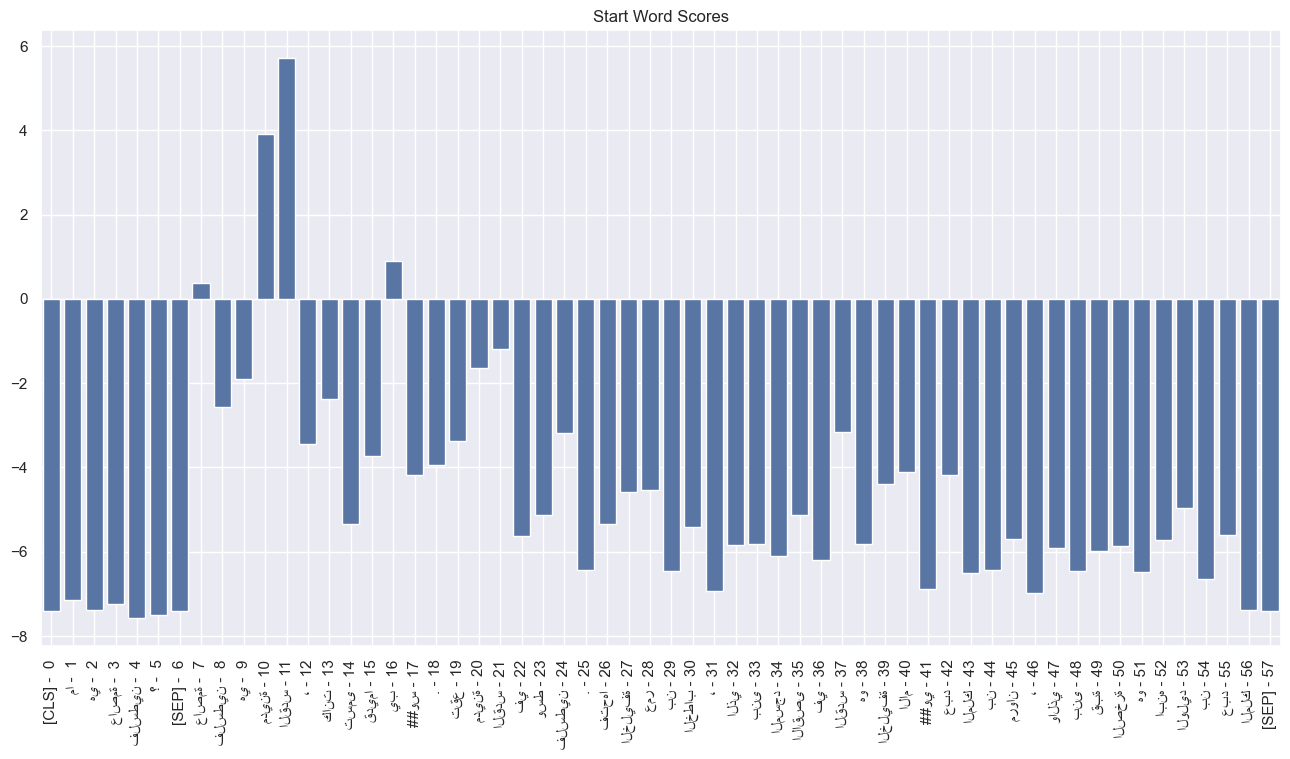

In [16]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()


Create a second bar plot showing the score for every input word being the "end" word.

C:\Users\DELL\AppData\Local\Temp\ipykernel_9820\2498766993.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9820\2498766993.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


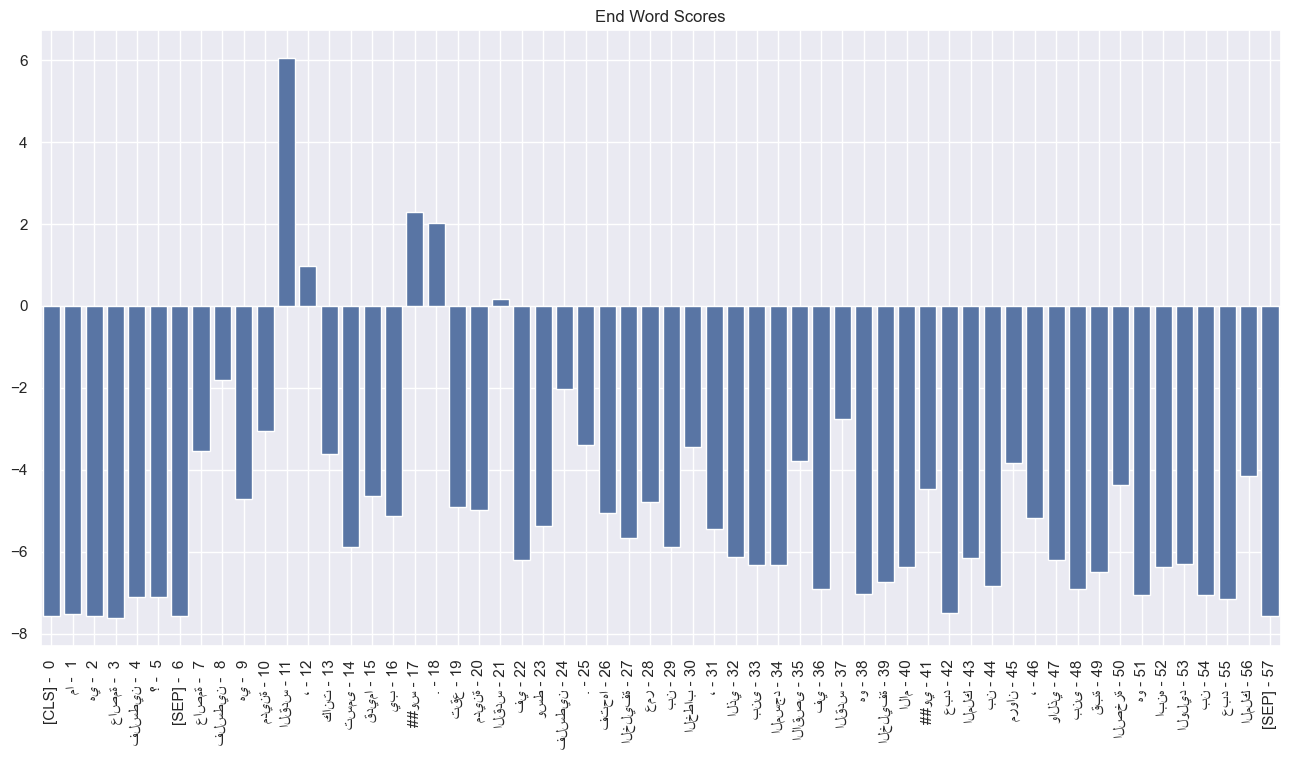

In [17]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()


**Alternate View**

We also tried visualizing both the start and end scores on a single bar plot, but I think it may actually be more confusing then seeing them separately.

In [18]:
import pandas as pd

# Store the tokens and scores in a DataFrame.
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label,
                   'score': s_scores[i],
                   'marker': 'start'})

    # Add  the token's end score as another row.
    scores.append({'token_label': token_label,
                   'score': e_scores[i],
                   'marker': 'end'})

df = pd.DataFrame(scores)


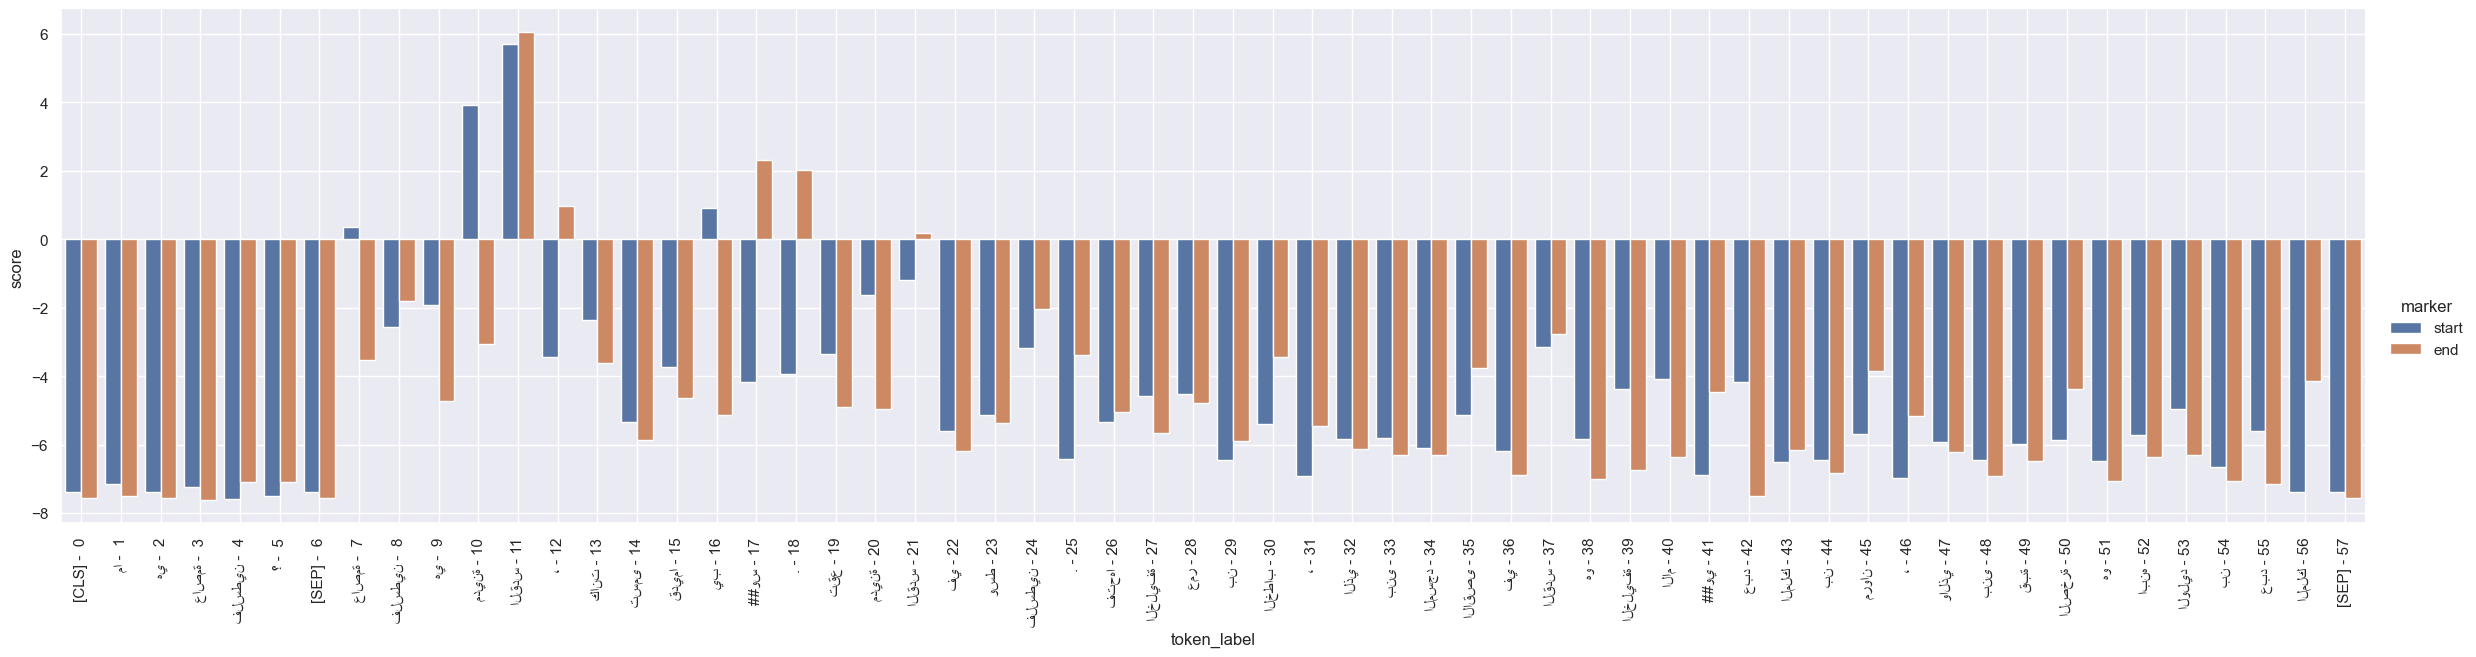

In [19]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)




## 5. More Examples

Turn the QA process into a function so we can easily try out other examples.

In [20]:
def answer_question(question1, answer_text2):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # preprocess the question and answer_text:
    question = prep_object.preprocess(question1)
    answer_text = prep_object.preprocess(answer_text2)
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example through the model.
    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                    token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                    return_dict=True)

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):

        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]

        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

Example 1:

In [21]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

bert_abstract = "عاصمة فلسطين هي مدينة القدس ، كانت تسمى قديماً يبوس. تقع مدينة القدس في وسط فلسطين. فتحها الخليفة عمر بن الخطاب، الذي بنى المسجد الاقصى في القدس هو الخليفة الاموي عبد الملك بن مروان، والذي بنى قبة الصخرة هو ابنه الوليد بن عبد الملك "

print(wrapper.fill(bert_abstract))

عاصمة فلسطين هي مدينة القدس ، كانت تسمى قديماً يبوس. تقع مدينة القدس في وسط
فلسطين. فتحها الخليفة عمر بن الخطاب، الذي بنى المسجد الاقصى في القدس هو الخليفة
الاموي عبد الملك بن مروان، والذي بنى قبة الصخرة هو ابنه الوليد بن عبد الملك


In [22]:
question = "ما هي عاصمة فلسطين؟"

answer_question(question, bert_abstract)

Query has 58 tokens.

Answer: "القدس"


In [23]:
question = "ماذا كانت تسمى قديماً؟ "

answer_question(question, bert_abstract)

Query has 58 tokens.

Answer: "يبوس"


In [24]:
question = "من بنى قبة الصخرة؟ "

answer_question(question, bert_abstract)

Query has 58 tokens.

Answer: "الوليد بن عبد الملك"


Example 2:

In [25]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

bert_abstract ="أبو عَبد الله مُحَمَّد بن مُوسَى الخَوارِزمي عالم رياضيات وفلك وجغرافيا مسلم. يكنى بأبي جعفر. قيل أنه ولد حوالي 164هـ 781م وقيل أنه توفيَ بعد 232 هـ أي (بعد 847م). يعتبر من أوائل علماء الرياضيات المسلمين حيث ساهمت أعماله بدور كبير في تقدم الرياضيات في عصره. اتصل بالخليفة العباسي المأمون وعمل في بيت الحكمة في بغداد وكسب ثقة الخليفة إذ ولاه المأمون بيت الحكمة كما عهد إليه برسم خارطة للأرض عمل فيها أكثر من سبعين جغرافيا. قبل وفاته في 850م/232هـ كان الخوارزمي قد ترك العديد من المؤلفات في علوم الرياضيات والفلك والجغرافيا ومن أهمها كتاب المختصر في حساب الجبر والمقابلة الذي يعد أهم كتبه."

print(wrapper.fill(bert_abstract))

أبو عَبد الله مُحَمَّد بن مُوسَى الخَوارِزمي عالم رياضيات وفلك وجغرافيا مسلم.
يكنى بأبي جعفر. قيل أنه ولد حوالي 164هـ 781م وقيل أنه توفيَ بعد 232 هـ أي (بعد
847م). يعتبر من أوائل علماء الرياضيات المسلمين حيث ساهمت أعماله بدور كبير في
تقدم الرياضيات في عصره. اتصل بالخليفة العباسي المأمون وعمل في بيت الحكمة في
بغداد وكسب ثقة الخليفة إذ ولاه المأمون بيت الحكمة كما عهد إليه برسم خارطة للأرض
عمل فيها أكثر من سبعين جغرافيا. قبل وفاته في 850م/232هـ كان الخوارزمي قد ترك
العديد من المؤلفات في علوم الرياضيات والفلك والجغرافيا ومن أهمها كتاب المختصر في
حساب الجبر والمقابلة الذي يعد أهم كتبه.


In [26]:
question = "اي الخلفاء ولى الخوارزمي بيت الحكمة ؟"

answer_question(question, bert_abstract)

Query has 144 tokens.

Answer: "المأمون"


**Example** 3:

In [27]:
import textwrap

# Wrap text to 100 characters.
wrapper = textwrap.TextWrapper(width=100)
bert_abstract = "درب التبانة (أو «الطريق اللبني») هي مجرة حلزونية الشكل. وهي اسم المجرة التي تنتمي إليها الشمس، والأرض، وبقية المجموعة الشمسية. تشتمل مجرة درب التبانة على مئات البلايين من النجوم، وتنتشر سحابات هائلة من الذرات والغبار والغازات في شتى أطراف المجرة. تحوي ما بين 200 إلى 400 مليار نجم؛ ففي الليالي المظلمة الصافية، يظهر درب التبانة على شكل حزمة لبنية عريضة من ضوء النجوم تمتد عبر السماء ولذلك تسمى أيضا الطريق اللبني. وتنشأ فجوات مظلمة في الحزمة نتيجة لتكون سحب الغبار والغازات التي تحجب الضوء المنبعث من النجوم التي وراءها. ومن ضمنهم الشمس. شكلها قرصي ويبلغ قطرها حوالي 185.000 سنة ضوئية وسمكها حوالي 1000 سنة ضوئية، فهي قرص رقيق جدا. ونحن نعيش قريبا من حافة تلك المجرة حيث تدور مجموعتنا الشمسية حول مركز المجرة. تبعد المجموعة الشمسية عن مركز المجرة نحو 27 ألف سنة ضوئية. وإذا نظر الشخص إلى السماء في الليل فقد يرى جزءًا من مجرتنا كحزمة من النجوم، ويرى سكان نصف الكرة الأرضية الشمالي درب التبانة في الصيف والخريف والشتاء. والمنظر في أواخر الصيف أو في مطلع الخريف يأخذ المدى الألمع والأغنى لهذا النهر السماوي: ففي ذلك الوقت من السنة، يمتد درب التبانة من برجي ذات الكرسي (كوكبة) والملتهب (كوكبة) في الشمال، عبر النصف الشرقي للسماء وعبر مجموعة نجوم تعرف كمثلث الصيف، ثم يغطس نحو الأفق خلال برجي القوس والعقرب. وتحجب الغيوم الفضائية بين برجي مثلث الصيف والقوس، رقعة مركزية واسعة من درب التبانة، مما يجعله يبدو منقسما إلى جدولين. وقرب برجي القوس والعقرب، يكون درب التبانة كثيفا ولامعا جدا، لأن هذا الاتجاه يدل نحو مركز المجرة."
print(wrapper.fill(bert_abstract))

درب التبانة (أو «الطريق اللبني») هي مجرة حلزونية الشكل. وهي اسم المجرة التي تنتمي إليها الشمس،
والأرض، وبقية المجموعة الشمسية. تشتمل مجرة درب التبانة على مئات البلايين من النجوم، وتنتشر سحابات
هائلة من الذرات والغبار والغازات في شتى أطراف المجرة. تحوي ما بين 200 إلى 400 مليار نجم؛ ففي الليالي
المظلمة الصافية، يظهر درب التبانة على شكل حزمة لبنية عريضة من ضوء النجوم تمتد عبر السماء ولذلك تسمى
أيضا الطريق اللبني. وتنشأ فجوات مظلمة في الحزمة نتيجة لتكون سحب الغبار والغازات التي تحجب الضوء
المنبعث من النجوم التي وراءها. ومن ضمنهم الشمس. شكلها قرصي ويبلغ قطرها حوالي 185.000 سنة ضوئية
وسمكها حوالي 1000 سنة ضوئية، فهي قرص رقيق جدا. ونحن نعيش قريبا من حافة تلك المجرة حيث تدور مجموعتنا
الشمسية حول مركز المجرة. تبعد المجموعة الشمسية عن مركز المجرة نحو 27 ألف سنة ضوئية. وإذا نظر الشخص
إلى السماء في الليل فقد يرى جزءًا من مجرتنا كحزمة من النجوم، ويرى سكان نصف الكرة الأرضية الشمالي درب
التبانة في الصيف والخريف والشتاء. والمنظر في أواخر الصيف أو في مطلع الخريف يأخذ المدى الألمع والأغنى
لهذا النهر الس

In [28]:
question = "كم قطر درب التبانة؟"

answer_question(question, bert_abstract)

Query has 343 tokens.

Answer: "185 . 000 سنة ضوئية"


**Evaluation**

---







In [30]:
import json
def evaluate_question(question, answer_text, ground_truth_answer):
    # Tokenize the input
    input_ids = tokenizer.encode(question, answer_text, truncation=True, max_length=512)

    # Set segment ids
    sep_index = input_ids.index(tokenizer.sep_token_id)
    segment_ids = [0] * (sep_index + 1) + [1] * (len(input_ids) - (sep_index + 1))

    # Convert to tensors
    input_ids = torch.tensor([input_ids])
    segment_ids = torch.tensor([segment_ids])

    # Get model outputs
    outputs = model(input_ids=input_ids, token_type_ids=segment_ids, return_dict=True)

    # Get start and end scores
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # Find the tokens with the highest start and end scores
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the predicted answer tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    predicted_answer = ""
    for i in range(answer_start, answer_end + 1):
        if tokens[i][0:2] == '##':
            predicted_answer += tokens[i][2:]
        else:
            predicted_answer += " " + tokens[i]

    # Calculate metrics
    predicted_answer = predicted_answer.strip().lower()
    ground_truth_answer = ground_truth_answer.strip().lower()

    # Calculate precision, recall, and F1 score
    precision = 0.0
    recall = 0.0
    f1_score = 0.0

    # Calculate precision and recall only if predicted answer and ground truth answer are non-empty
    if predicted_answer and ground_truth_answer:
        predicted_tokens = set(predicted_answer.split())
        ground_truth_tokens = set(ground_truth_answer.split())

        common_tokens = predicted_tokens.intersection(ground_truth_tokens)
        num_common_tokens = len(common_tokens)

        # Calculate precision, recall, and F1 score with denominator check
        if len(predicted_tokens) > 0:
            precision = num_common_tokens / len(predicted_tokens)
        if len(ground_truth_tokens) > 0:
            recall = num_common_tokens / len(ground_truth_tokens)
        if precision + recall > 0:
            f1_score = (2 * precision * recall) / (precision + recall)

    return precision, recall, f1_score


In [32]:
# Define a function to load the dataset from a JSON file
def load_dataset_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
    return dataset

In [ ]:
# Example usage: Load dataset from JSON file
dataset_file_path = 'AAQAD-dev.json'
dataset = load_dataset_from_file(dataset_file_path)

In [110]:
def evaluate_question_answering_system(dataset):
    results = []
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    total_accuracy = 0
    total_examples = 0

    for entry in dataset['data']:
        title = entry['title']
        for paragraph in entry['paragraphs']:
            for qa in paragraph['qas']:
                question = qa['question']
                answers = qa['answers']
                for answer in answers:
                    answer_text = answer['text']
                    ground_truth_answer = answer_text

                    # Call the evaluate_question function to calculate precision, recall, and F1 score
                    precision, recall, f1_score = evaluate_question(question, answer_text, ground_truth_answer)

                    # Calculate accuracy by comparing the predicted answer with the ground truth answer
                    predicted_answer = ""
                    if f1_score > 0:
                        predicted_answer = answer_text.lower()

                    accuracy = int(predicted_answer == ground_truth_answer.lower())

                    result = {
                        'title': title,
                        'question': question,
                        'answer_text': answer_text,
                        'ground_truth_answer': ground_truth_answer,
                        'precision': precision,
                        'recall': recall,
                        'f1_score': f1_score,
                        'accuracy': accuracy
                    }
                    results.append(result)

                    total_precision += precision
                    total_recall += recall
                    total_f1_score += f1_score
                    total_accuracy += accuracy
                    total_examples += 1

    average_precision = total_precision / total_examples
    average_recall = total_recall / total_examples
    average_f1_score = total_f1_score / total_examples
    average_accuracy = total_accuracy / total_examples

    evaluation_results = {
        'average_precision': average_precision,
        'average_recall': average_recall,
        'average_f1_score': average_f1_score,
        'average_accuracy': average_accuracy,
        'results': results
    }

    return evaluation_results

In [76]:
evaluation_results = evaluate_question_answering_system(dataset)


In [111]:
print("Average Precision:", evaluation_results['average_precision'])
print("Average Recall:", evaluation_results['average_recall'])
print("Average F1 Score:", evaluation_results['average_f1_score'])
print("Average Accuracy:", evaluation_results['average_accuracy'])

Average Precision: 0.587977763095387
Average Recall: 0.4846490980897498
Average F1 Score: 0.49491750788452715
Average Accuracy: 0.6538139145012574
